In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivpimport numpy as np
##############################################################
####   Functions for bounding finite differences error   #####
##############################################################
"""
Computes the coefficients of the derivitve of the kth Lagrangian Coefficients.
These are also the coefficients used for finite differences.
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
"""
Sums up the above coefficients and is needed for calculating the measurment error
n: number of data points used for approximation/ order
l: input to lagrange coefficient: x = x_l = x+ hl
"""
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

"""
Approximation error for central differences: reduces with higher order
The approximation error is caused by finite differences itself.
"""
def appr_error_central_diff(order):
    assert(order%2==0) #Check if n is even
    bound = (np.math.factorial(int(order/2))**2)/np.math.factorial(order+1)
    return bound
    
# Approximation error backward differences
def appr_error_backward_diff(n):
    return 1/(n+1)

"""
Measurement error for central differences.
The measurement error is caused round off errors and does not decrease for higher order.
"""
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg
    
"""
Error bound on the first derivative calculated with finite differences
eps: measurement error+round of error
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound_finite_diff(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

##############################################################
####       Functions for bounding condition error        #####
##############################################################
"""
Computes error_bound  for ||g-g_noise||_F^2, where g=(u ux)
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound_finite_diff(eps_infty,h,M,order)**2
    return E

"""
Computes total error on condition o1/o2 without considering the supremum
E: error bound on ||g-g_noise||_F^2 calculated in above functions
sv_max: highest singular value on matrix without noise
sv_min: lowest singular value on matrix without noise
"""
def error_bound_condition(E,sv_max,sv_min):
    bound = np.sqrt(1/sv_min+(sv_max/sv_min**2)**2*E)
    return bound


##############################################################
#### Functions for bounding reversed condition error     #####
##############################################################

"""
This function should upper bound the reversed condition for singular matrices 
where on>C2>0
C1:lower bound of biggest singular value: C <= o_max
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
"""
def upper_bound_singular_matrix(C,eps):
    if C-eps<=0:
        print(f"Error is too big C<eps with C = {C:.3e}, eps = {eps:.3e}: no upper bound can be calculated")
        return 1.0
        
    bound= eps/(C-eps)*np.sqrt(1+(eps/(C-eps))**2) 
    bound = min(bound, 1.0) # o_min/o_max <=1 in all cases
    return bound

"""
This function should lower bound the reversed condition for nonsingular matrices 
where on>C2>0
C1: upper bound for o1 < C1
C2: lower bound for on > C2 > 0
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
The question is how to choose C2??
"""
def lower_bound_nonsingular_matrix(C1,C2,eps):
    bound= (C2-eps)/(C1+eps)
    bound = max(bound,1e-10)
    return bound
    
"""Threshold if values are beneath classify as non unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C: lower bound of biggest singular value: C <= o_max
"""
def calc_threshold_nonuniq(E,C):
    T = upper_bound_singular_matrix(C,E)
    return T
    
"""Threshold if values are above classify as unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C1: upper bound of biggest singular value: C1 => o_max
C2: upper bound of biggest singular value: C2 <= o_max
"""
def calc_threshold_uniq(C1,C2,E):
    T = lower_bound_nonsingular_matrix(C1,C2,E)
    return T
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

# Function with non unqiue PDE: $u(t,x)=sin(x+t)$
We have here that $u$ solves the equations $u_t = u_x$ and $u_t= u_x+\lambda (u^2+u_x^2-1)$. Two things we can do here: show that the Jacobi criterion for analytic PDEs does not help and then apply the methods for polynomials to show non-uniqueness.  This time, we will add gaussian noise with standard deviation of $0.01u$.

In [2]:
x_0, x_end = 0, 5
t_0, t_end = 0, 5
nx, nt = (300, 200)
x = np.linspace(x_0, x_end, nx)
t = np.linspace(t_0, t_end, nt)
tv, xv = np.meshgrid(t, x)

u = np.sin(xv + tv)
u += np.random.normal(scale=np.abs(u)*0.01, size=u.shape)

In [6]:
u.shape

(300, 200)

In [9]:
dt, u[0].shape

(0.02512562814070352, (200,))

In [7]:
ps.FiniteDifference(axis=0)._differentiate(u[0], t=dt)

array([ 0.99553777,  1.01110469,  0.99313641,  1.00512348,  1.01145383,
        0.97903167,  0.93847372,  0.97033028,  1.02839957,  0.95930644,
        0.98075187,  0.95012137,  0.98331495,  1.02764124,  0.87886667,
        0.84222577,  1.01271629,  0.9133255 ,  0.71222597,  1.0813767 ,
        1.13299529,  0.68242063,  0.60494831,  0.88467095,  1.02470291,
        0.87662556,  0.85446853,  0.64808933,  0.59983627,  0.81828739,
        0.51990445,  0.57293334,  1.01530158,  0.8964428 ,  0.46700093,
        0.71103805,  0.41827239,  0.19164167,  0.64368352,  0.68589349,
        0.62567798,  0.6073627 ,  0.49933777,  0.70081345,  0.24420029,
        0.015801  ,  0.78098335,  0.25913984,  0.56684165,  0.40827055,
       -0.07148082,  0.32958035,  0.20595164,  0.43858506,  0.4716868 ,
       -0.00271141,  0.31001514,  0.29172428, -0.30936992, -0.07112626,
        0.24328171,  0.26057373,  0.01199516, -0.3846884 , -0.24732104,
        0.38445021,  0.26559612, -0.03147741, -0.56410754, -0.72

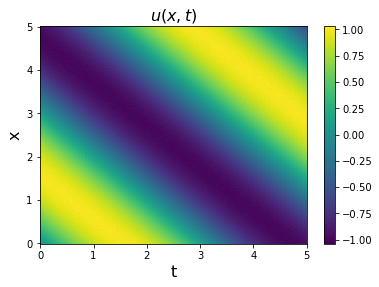

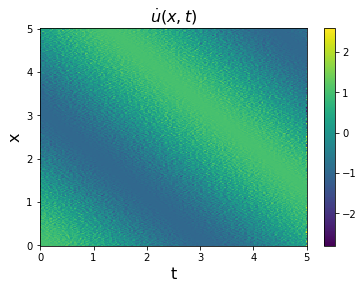

In [3]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

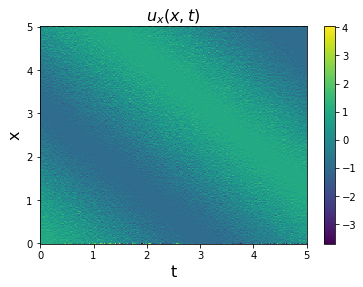

In [4]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)


# Plot derivative results
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

In [5]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=1, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 1.072 x0_1 + -0.709 x0x0x0_1
SR3 model, L0 norm: 
(x0)' = 1.072 x0_1 + -0.709 x0x0x0_1
SR3 model, L1 norm: 
(x0)' = 0.002 1 + -0.006 x0 + 0.003 x0x0 + 1.072 x0_1 + -0.004 x0x0_1 + -0.710 x0x0x0_1
SSR model: 
(x0)' = 0.002 1 + -0.006 x0 + 0.003 x0x0 + 1.072 x0_1 + -0.004 x0x0_1 + -0.710 x0x0x0_1
SSR (metric = model residual) model: 
(x0)' = 0.002 1 + -0.006 x0 + 0.003 x0x0 + 1.072 x0_1 + -0.004 x0x0_1 + -0.710 x0x0x0_1
FROLs model: 
(x0)' = 1.072 x0_1 + -0.709 x0x0x0_1


So, we see that all models find the desired equation.
## Check now numerically if this is the unique equation

We already know that the equation is not unique. First we want to show that the Jacobi criterion for analytic PDEs does not help, as it can only be used to show uniqueness and as $u$ is not algebraic we cannot use the other direction.
### Jacobi criterion

In [6]:
from numpy.linalg import matrix_rank, svd

In [7]:
fd_order = 3
ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u, t=dt)
utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u, dx) 
ut.shape

(300, 200, 1)

In [8]:
x_i, t_j = 10, 10
ut[x_i,t_j], ux[x_i,t_j], utx[x_i,t_j], uxx[x_i,t_j]

(array([0.96623558]),
 array([0.63221625]),
 array([-14.39852882]),
 array([-23.7485244]))

In [9]:
jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
jacobian, svd(jacobian, compute_uv=False)

(array([[  0.96623558,   0.63221625],
        [-14.39852882, -23.7485244 ]]),
 array([27.7919994 ,  0.49811765]))

In [10]:
space_range = 28
time_range = 18
sv_ratios = np.zeros([space_range, time_range])
for i in range(space_range):
    for j in range(time_range):
        x_i, t_j = i * 10 + 10, j * 10 + 10
        jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
        svs = svd(jacobian, compute_uv=False)
        sv_ratio = svs[0] / svs[-1]
        sv_ratios[i,j] = sv_ratio
np.min(sv_ratios)

1.20495718859457

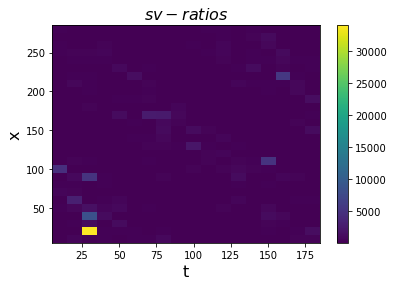

In [11]:
t_grid, x_grid = np.arange(time_range) * 10 + 10, np.arange(space_range) * 10 + 10
# Plot derivative results
plt.pcolormesh(t_grid, x_grid, sv_ratios)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$sv-ratios$', fontsize=16)
plt.colorbar()
plt.show()

## Polynomial criterion
Let us validate now our believe that it is actually not the unique PDE by checking the condition of the feature matrix consisting out of $u$, $u_x$ and their derivatives.

In [12]:
from itertools import product

In [13]:
def monomials(features, order):
    multi_indices = []
    indices = np.arange(order + 1)
    number_features = features.shape[0]
    repeat_indices = [indices for i in range(number_features)]
    for i in product(*repeat_indices):
        if sum(i) <= order:
            multi_indices += [i]
    new_features = []
    for multi_index in multi_indices:
        new_feature = 1
        for i, j in enumerate(multi_index):
            new_feature *= features[i]**j
        new_features.append(new_feature.reshape(1,-1))
    return np.concatenate(new_features,axis=0)

In [14]:
fd_order = 3
ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux.flatten()

In [15]:
base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
base_features.shape

(2, 60000)

In [16]:
library = monomials(base_features, order=2)
library.shape

(6, 60000)

In [17]:
matrix_rank(library), svd(library, compute_uv=False)

(6,
 array([356.09710313, 213.61300387, 177.96694861, 165.18659805,
        140.65763444,  71.16809841]))

Looks like we have actually algebraic dependence here but let us check the 
### Singular value ratio plot

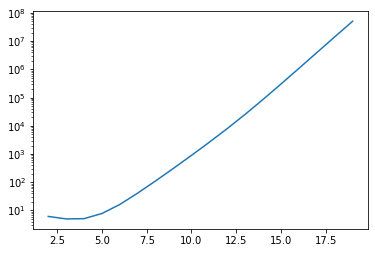

In [18]:
polynomial_order = 2
distance_svs = []
fd_orders = range(2, 20)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat = u.flatten(), ux.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])
plt.plot(range(2,20), distance_svs)
plt.yscale('log')

So, we can conclude that it is actually not the unique PDE (as we knew before already).